In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pk
import matplotlib as mpl
import json
import pandas as pd
import seaborn as sns

In [2]:
#city = 'Athens'
#city = 'Barcelona'
#city = 'Budapest'
#city = 'Edinburgh'
#city = 'Glasgow'
city = 'Perth'
#city = 'London'
#city = 'Madrid'
#city = 'Melbourne'
#city = 'NewDelhi'
#city = 'Osaka'
#city = 'Perth'
#city = 'Toronto'
#city = 'Vienna'

In [3]:
#POI_BANDWIDTH_CAPACITY = 150
#MEC_CAPACITY = 37.5

## Convergence

In [4]:
file = open('results/' + city + '/reward', 'rb')
reward = pk.load(file)

In [5]:
len(reward)

100

In [6]:
def plot_convergence(reward):
    mpl.rcParams['figure.dpi']= 300
    plt.rcParams["figure.figsize"] = [5, 3]
    fig, ax = plt.subplots()
    xpoints = np.array([i for i in range(1, len(reward)+1)])
    ypoints = np.array(reward)

    ax.set_title('Convergência - ' + city)
    plt.xlabel("Episodio de treinamento")
    plt.ylabel("Recompensa média")
    plt.plot(xpoints, ypoints)
    plt.savefig("results/" + city + "/plots/convergence.pdf", bbox_inches='tight')
    plt.show()

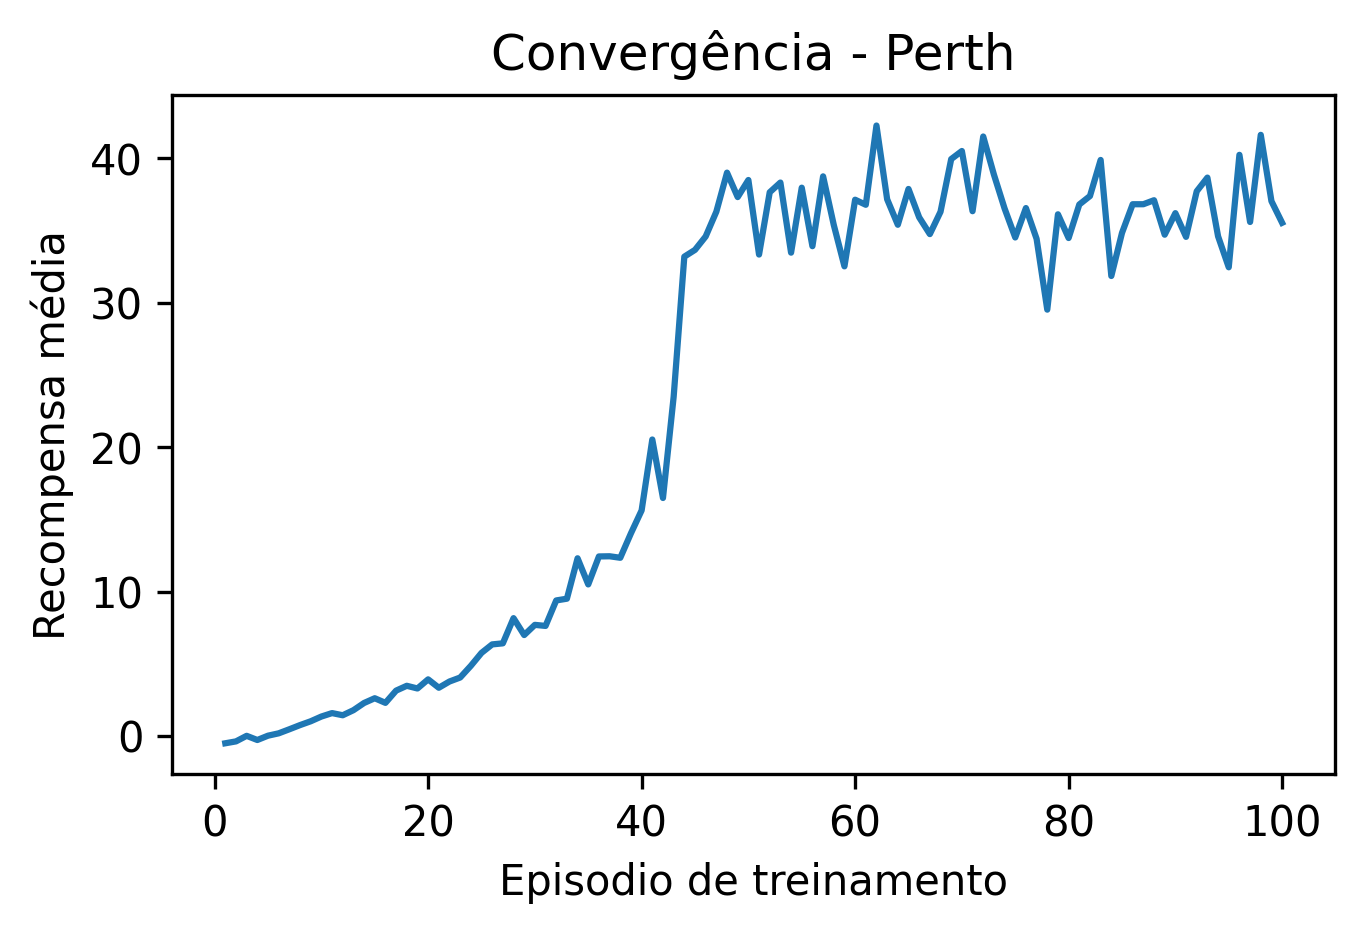

In [7]:
plot_convergence(reward)

## Recall and Precision

In [8]:
f = open('results/' + city + '/75_result.json')
data = json.load(f)

In [9]:
number_of_users = len(data.keys())

In [10]:
def intersection(list_a, list_b):
    return [ e for e in list_a if e in list_b ]

In [11]:
Total_R = []
Total_P = []
Mean_R = 0
Mean_P = 0
instances = 0
for item in data.keys():
    if(len(data[item]['original']) >= 2):
        recall = len(intersection(data[item]['original'], data[item]['recommendation']))/len(data[item]['original'])
        precis = len(intersection(data[item]['original'], data[item]['recommendation']))/len(data[item]['recommendation'])
        Mean_P = Mean_P + precis
        Mean_R = Mean_R + recall
        Total_R.append(recall)
        Total_P.append(precis)
        instances = instances + 1
    
Mean_P = Mean_P / instances
Mean_R = Mean_R / instances

In [12]:
def plot_cdf_recall_precision(Total_R, Total_P, Mean_R, Mean_P):
    #sns.set_theme(style="darkgrid")
    mpl.rcParams['figure.dpi']= 300

    plt.rcParams["figure.figsize"] = [5, 3]
    plt.rcParams["figure.autolayout"] = True

    data1 = Total_R
    data2 = Total_P
    
    count1, bins_count1 = np.histogram(data1, bins=100)
    pdf1 = count1 / sum(count1)
    cdf1 = np.cumsum(pdf1)
    plt.plot(bins_count1[1:], cdf1, label="CDF Recall", color='#cc0066')
    plt.plot(0.5, Mean_R, 'o', label="Recall Mean", color='#009933')
    
    count2, bins_count2 = np.histogram(data2, bins=100)
    pdf2 = count2 / sum(count2)
    cdf2 = np.cumsum(pdf2)
    plt.plot(bins_count2[1:], cdf1, label="CDF Precision", color='#111111')
    plt.plot(0.5, Mean_P, 's', label="Precision Mean", color='#009933')
    
    plt.xlabel("Metrics", fontsize=16)
    plt.ylabel("Percentage", fontsize=16)
    
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    
    plt.grid(linestyle = '--')
    plt.legend()
    plt.savefig("results/" + city + "/plots/recall_precision.pdf", bbox_inches='tight')
    plt.show()

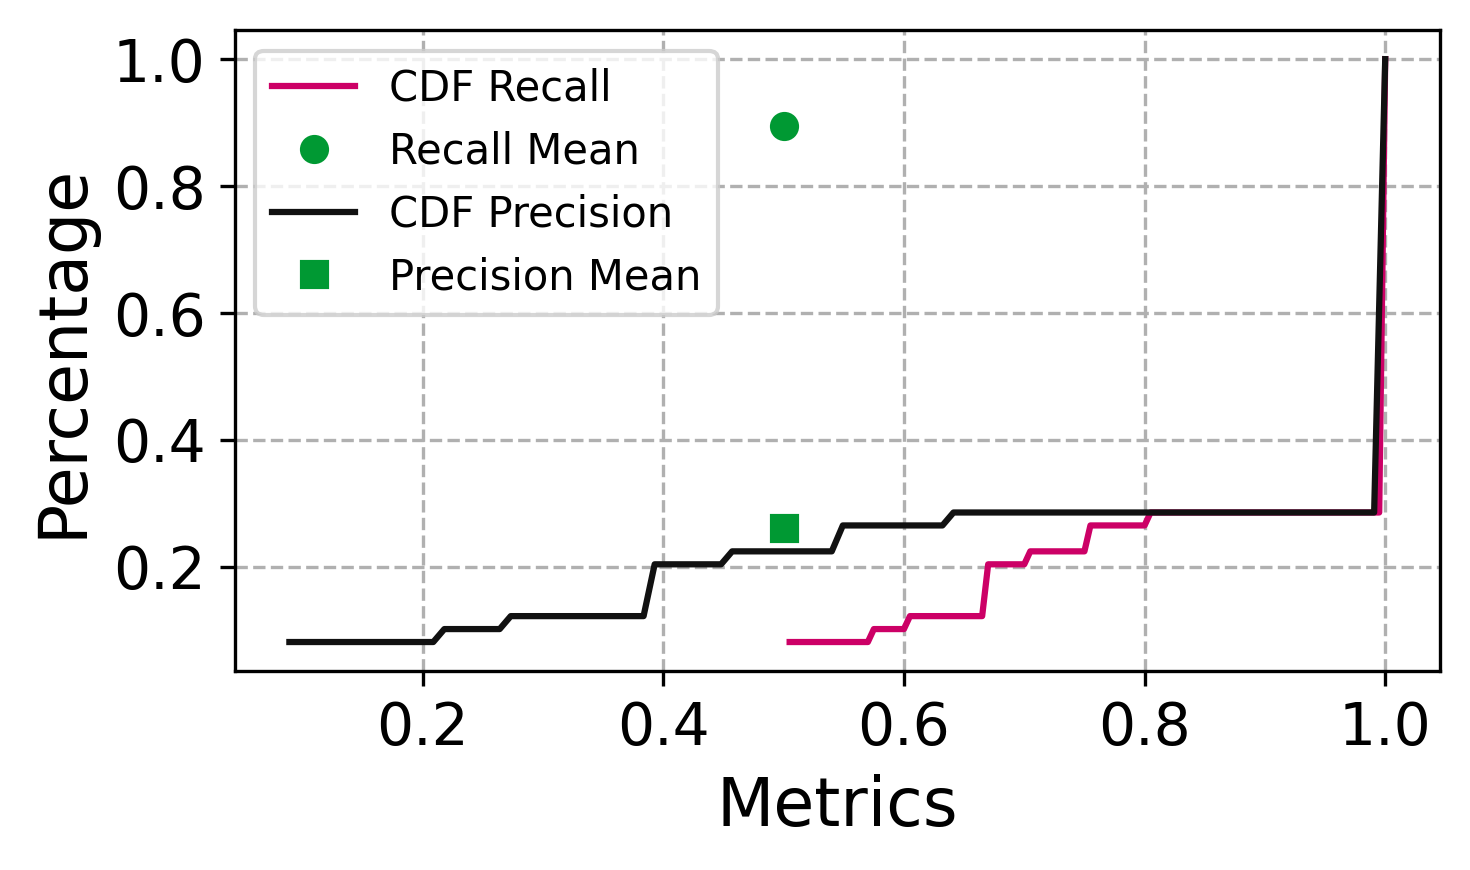

In [13]:
plot_cdf_recall_precision(Total_R, Total_P, Mean_R, Mean_P)

## POI Resurce Usage

In [14]:
pois = pd.read_csv("data_process/_RawData/" + city + "/POIs.csv")
quantity_of_POIS = len(pois)

POI_to_ID = {}
ID_to_POI = {}
index = 0
for poi in list(pois['poiID']):
    POI_to_ID[poi] = index
    ID_to_POI[index] = poi
    index = index + 1

In [15]:
def process_data_for_max_mec_band_usage_per_poi(data):
    bandwidth_temporal_usage = np.zeros(shape=(quantity_of_POIS,quantity_of_POIS))
    mec_temporal_usage = np.zeros(shape=(quantity_of_POIS,quantity_of_POIS))
    bandwidth_temporal_usage[:] = np.nan
    mec_temporal_usage[:] = np.nan

    for item in data:
        #print(item)
        t = 0
        for poi in data[item]['recommendation']:
            poi_index = POI_to_ID[poi]
            if(np.isnan(bandwidth_temporal_usage[poi_index][t])):
                bandwidth_temporal_usage[poi_index][t] = 0

            if(np.isnan(mec_temporal_usage[poi_index][t])):
                mec_temporal_usage[poi_index][t] = 0

            bandwidth_temporal_usage[poi_index][t] = bandwidth_temporal_usage[poi_index][t] + data[item]['allocated_bandwidth'][t]
            mec_temporal_usage[poi_index][t] = mec_temporal_usage[poi_index][t] + data[item]['allocated_mec'][t]
            t = t + 1

    max_mec_usage_per_poi = []
    max_bandwidth_usage_per_poi = []
    for item in range(0, quantity_of_POIS):
        max_bandwidth_usage_per_poi.append(np.nanmax(bandwidth_temporal_usage[item]))
        max_mec_usage_per_poi.append(np.nanmax(mec_temporal_usage[item]))
        
    return (max_mec_usage_per_poi, max_bandwidth_usage_per_poi)

In [16]:
def plot_max_mec_band_usage_per_poi(pois, max_mec_usage, max_band_usage, MEC_CAPACITY, POI_BANDWIDTH_CAPACITY):

    fig = plt.figure(figsize = (10,3))

    # creating the bar plot
    #plt.bar(pois, max_usage, color ='#006666',
    #        width = 0.8)
    
    #plt.fill_between(pois, max_band_usage, color ='#006699', label='Bandwidth usage')
    #plt.fill_between(pois, max_mec_usage, color ='#ff9900', label='MEC usage')
    
    plt.fill_between(pois, max_band_usage, color ='#006699', label='Bandwidth usage')
    plt.fill_between(pois, max_mec_usage, color ='#cc0066', label='MEC usage')
    
    plt.plot(pois, max_mec_usage, color ='#FFFFFF', linewidth=0.5)
    
    plt.plot([1, len(pois)], [MEC_CAPACITY, MEC_CAPACITY], color='r', linestyle='--', linewidth=1)
    plt.plot([1, len(pois)], [POI_BANDWIDTH_CAPACITY, POI_BANDWIDTH_CAPACITY], color='r', linestyle='--', linewidth=1)
    
    plt.xticks([1, len(pois)])
    #plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
    ticks = list(range(0, POI_BANDWIDTH_CAPACITY+1, int(POI_BANDWIDTH_CAPACITY/5)))
    plt.yticks(ticks)
    
    plt.xlabel("Point of Interest ID")
    plt.ylabel("Maximum MEC usage (RCs)")
    #plt.title("Students enrolled in different courses")
    plt.legend()
    plt.grid(axis = 'y')
    plt.savefig("results/" + city + "/plots/" + str(POI_BANDWIDTH_CAPACITY) + "_mec_band_usage.pdf", bbox_inches='tight')
    plt.show()

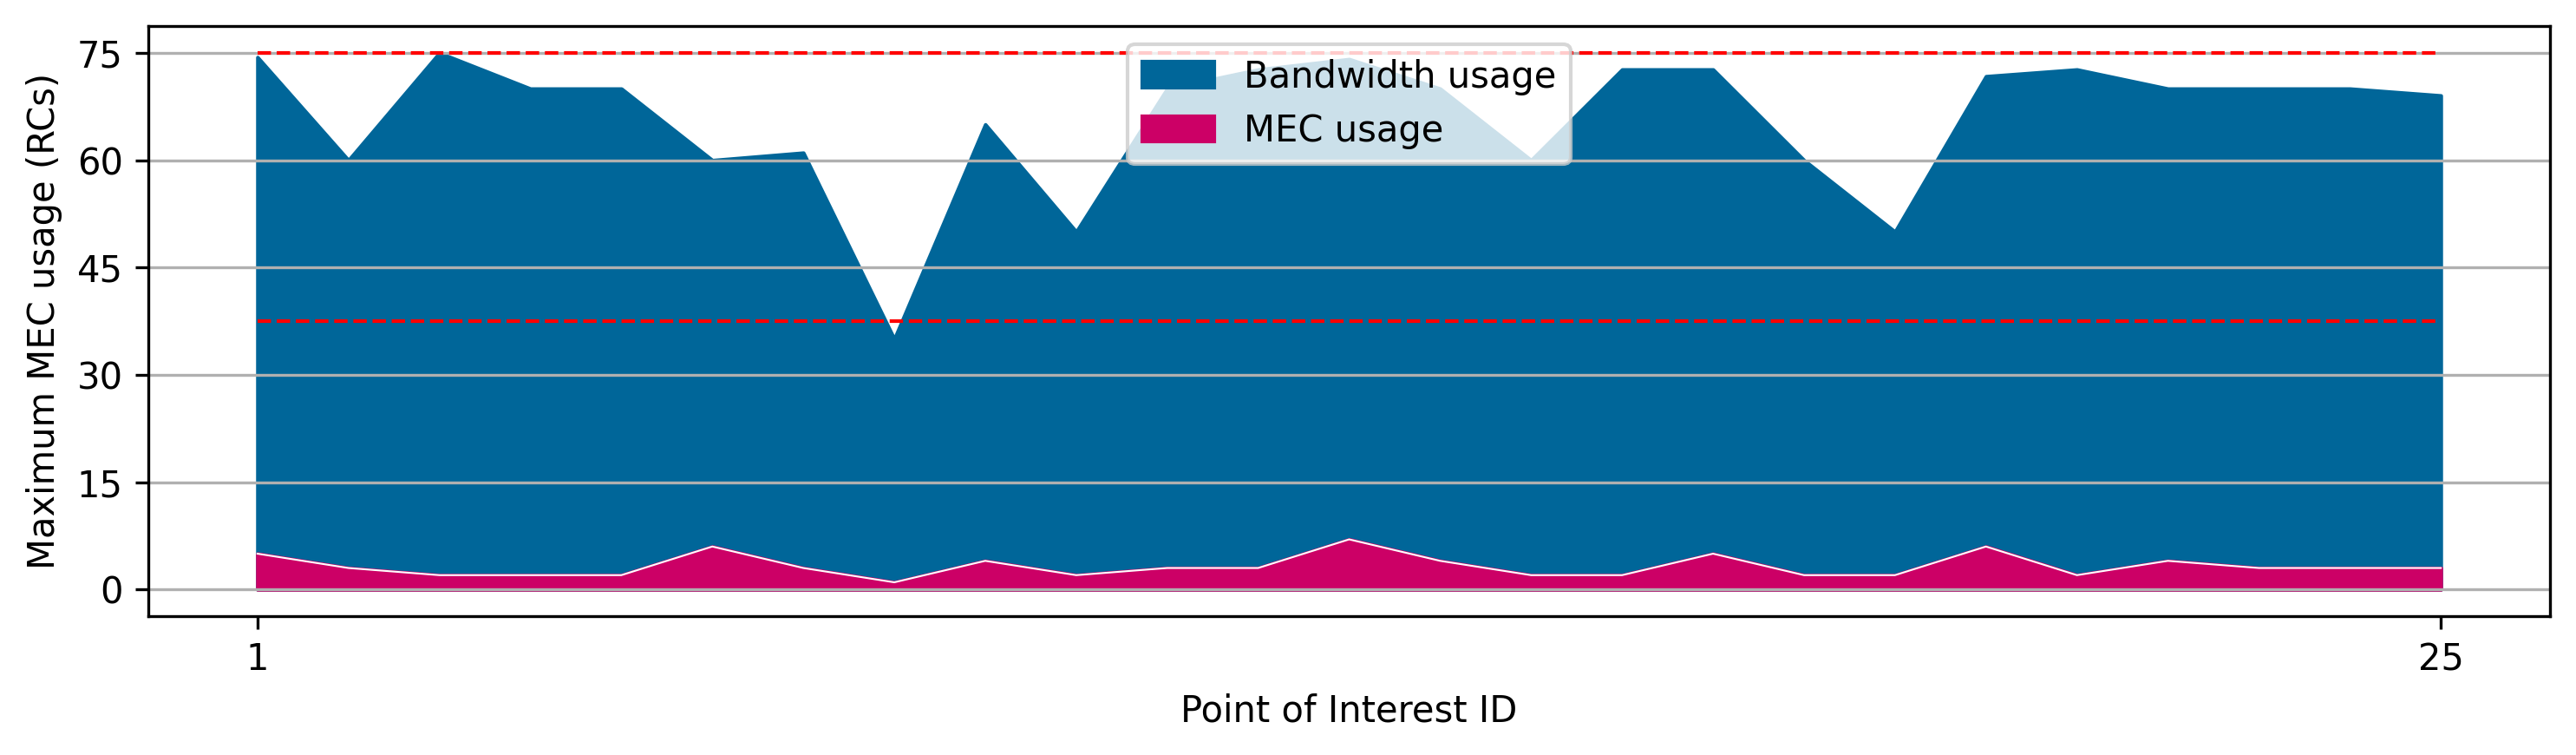

In [17]:
f = open('results/' + city + '/75_result.json')
data = json.load(f)
max_mec_usage_per_poi, max_bandwidth_usage_per_poi = process_data_for_max_mec_band_usage_per_poi(data)
plot_max_mec_band_usage_per_poi(list(pois['poiID']), max_mec_usage_per_poi, max_bandwidth_usage_per_poi, 37.5, 75)

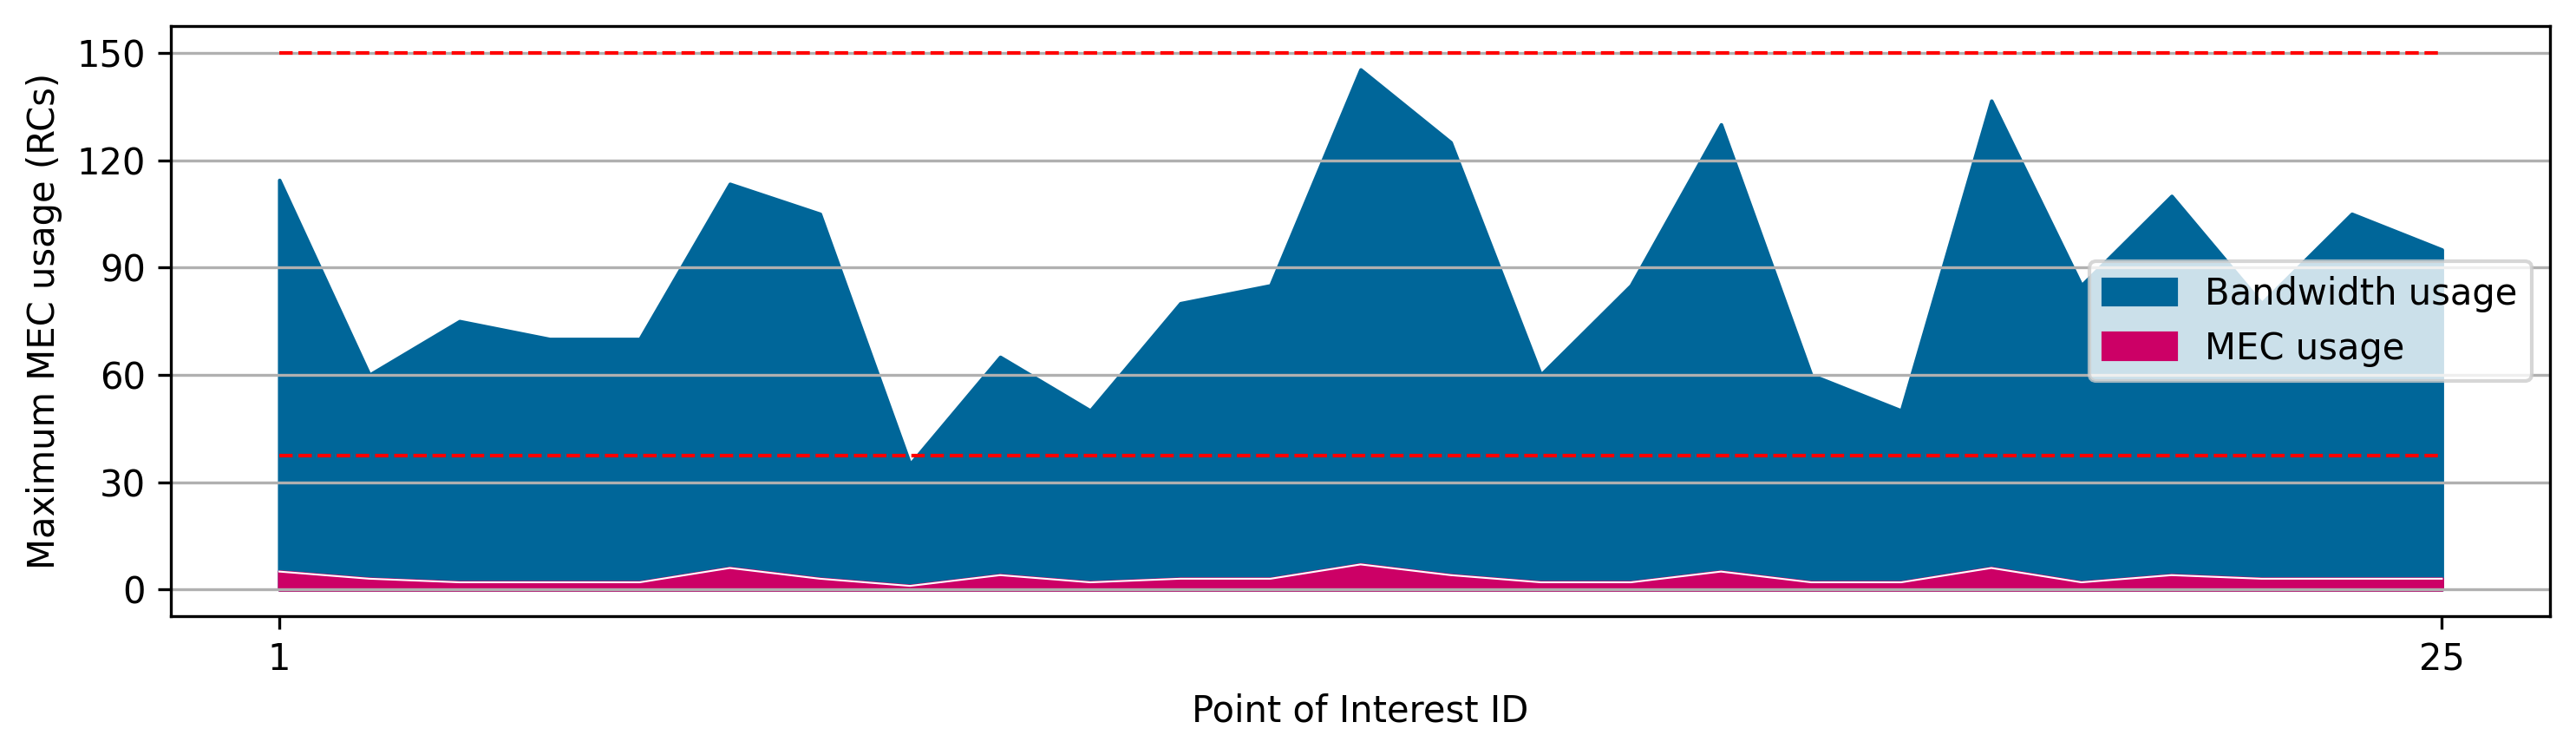

In [18]:
f = open('results/' + city + '/150_result.json')
data = json.load(f)
max_mec_usage_per_poi, max_bandwidth_usage_per_poi = process_data_for_max_mec_band_usage_per_poi(data)
plot_max_mec_band_usage_per_poi(list(pois['poiID']), max_mec_usage_per_poi, max_bandwidth_usage_per_poi, 37.5, 150)

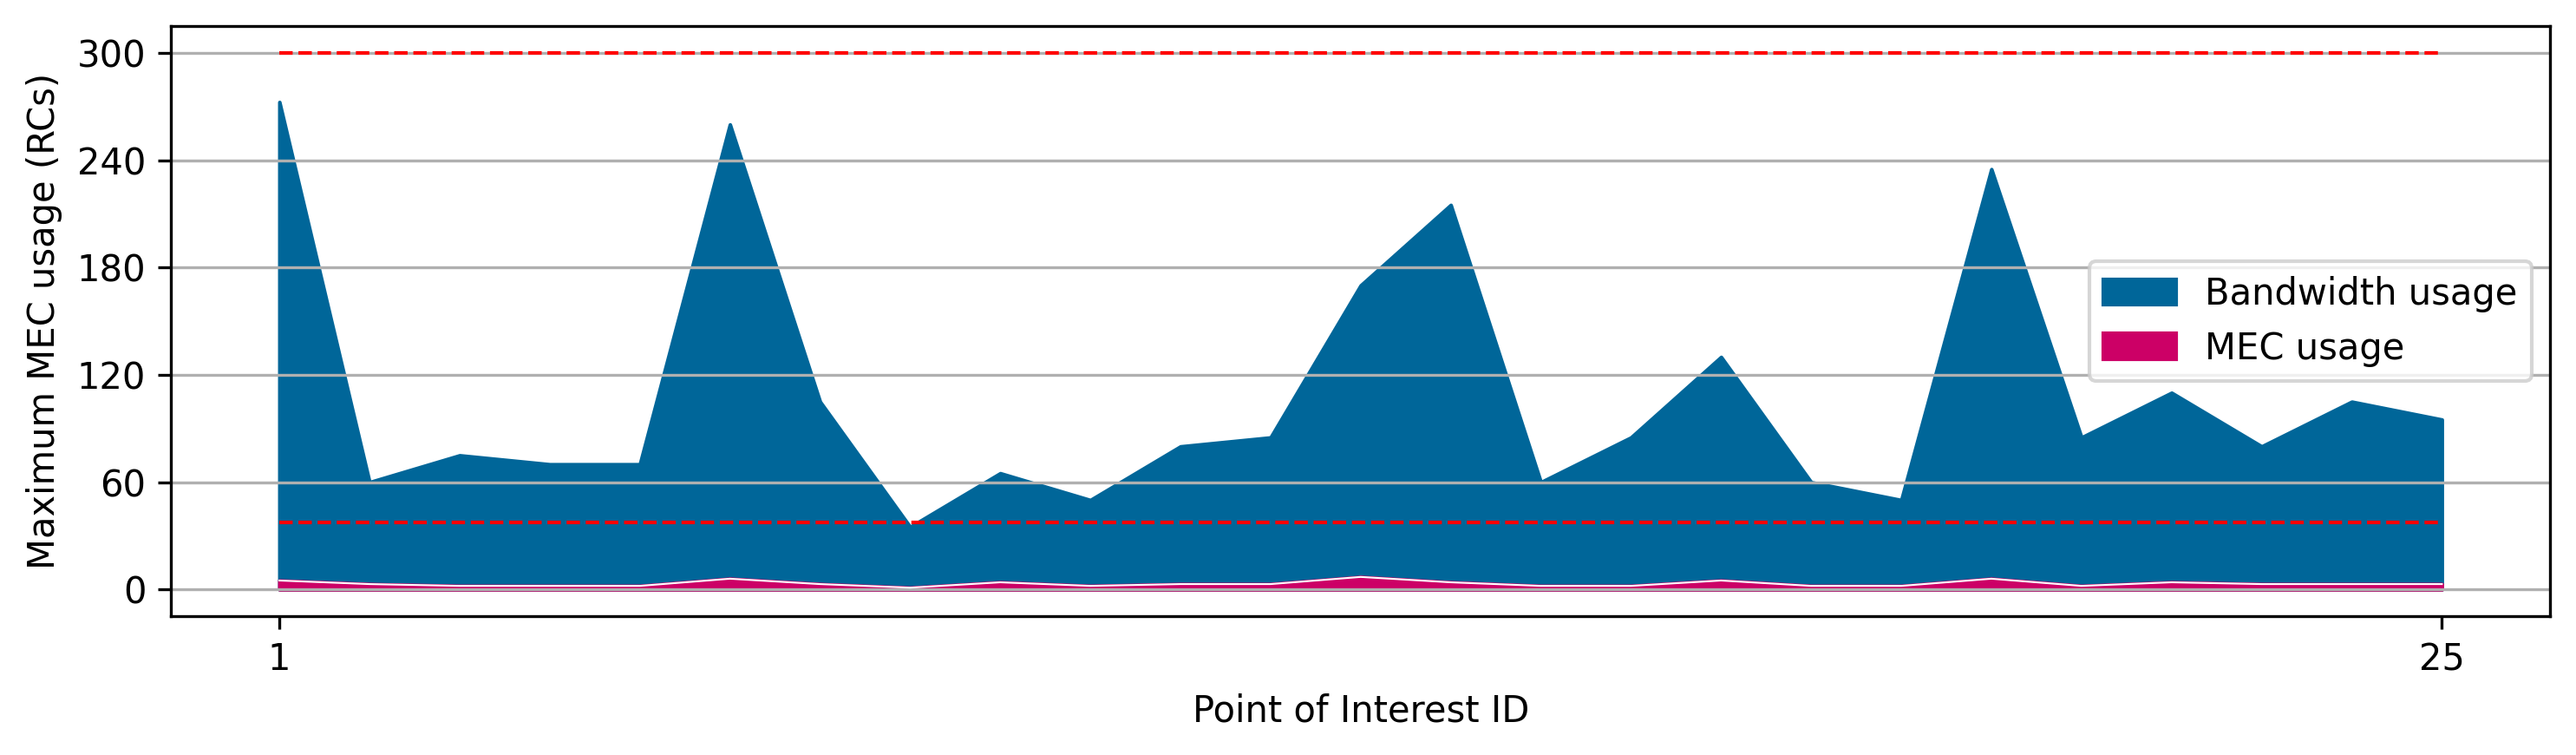

In [19]:
f = open('results/' + city + '/300_result.json')
data = json.load(f)
max_mec_usage_per_poi, max_bandwidth_usage_per_poi = process_data_for_max_mec_band_usage_per_poi(data)
plot_max_mec_band_usage_per_poi(list(pois['poiID']), max_mec_usage_per_poi, max_bandwidth_usage_per_poi, 37.5, 300)

## User resource allocation

In [20]:
def process_data_for_plot_diff(data):
    diff_of_b_allocation = []
    diff_of_m_allocation = []

    for item in data:
        if(data[item]['demand_bandwidth'][1] != 0):
            min_all = round(min(data[item]['allocated_bandwidth']), 6)
            min_dem = data[item]['demand_bandwidth'][0]
            diff_of_b_allocation.append(min_all - min_dem)

        if(data[item]['demand_mec'][1] != 0):
            min_all = round(min(data[item]['allocated_mec']), 6)
            min_dem = data[item]['demand_mec'][0]
            diff_of_m_allocation.append(min_all - min_dem)

    diff_of_b_allocation = np.array(diff_of_b_allocation)
    diff_of_m_allocation = np.array(diff_of_m_allocation)


    non_negative_b_diff = diff_of_b_allocation.copy()
    negative_b_diff = diff_of_b_allocation.copy()

    non_negative_b_diff[non_negative_b_diff < 0] = np.nan
    negative_b_diff[negative_b_diff > 0] = np.nan

    non_negative_m_diff = diff_of_m_allocation.copy()
    negative_m_diff = diff_of_m_allocation.copy()

    non_negative_m_diff[non_negative_m_diff < 0] = np.nan
    negative_m_diff[negative_m_diff >= 0] = np.nan
    
    return (non_negative_b_diff, negative_b_diff, non_negative_m_diff, negative_m_diff)

In [21]:
def plot_diff_band(non_negative_dif, negative_dif, limit_b):
    mpl.rcParams['figure.dpi']= 300
    plt.rcParams["figure.figsize"] = [5, 3]
    fig, ax = plt.subplots()
    xpoints = np.array([i for i in range(1, len(non_negative_dif)+1)])
    
    ax.set_title('Bandwidth allocation - ' + city)
    plt.xlabel("Users")
    plt.ylabel("Allocation - demmand")
    plt.xticks([1, len(non_negative_dif)])
    
    pos_dif = str(round((np.count_nonzero(~np.isnan(non_negative_dif))/len(non_negative_dif))*100, 0))
    neg_dif = str(round((np.count_nonzero(~np.isnan(negative_dif))/len(non_negative_dif))*100, 0))
    
    plt.plot(xpoints, non_negative_dif, '.', markerfacecolor='none', markeredgewidth=0.5, label='Positive difference ~ ' + pos_dif + '%')
    plt.plot(xpoints, negative_dif, '.', markerfacecolor='none', markeredgewidth=0.5, label='Negative difference ~ ' +  neg_dif + '%')
    
    plt.legend(fontsize=8)
    
    plt.grid(axis = 'y', linestyle='--', linewidth=0.6)
    plt.savefig("results/" + city + "/plots/" + str(limit_b) + "_difference_bandwidth.pdf", bbox_inches='tight')
    plt.show()

In [22]:
def plot_diff_mec(non_negative_dif, negative_dif):
    mpl.rcParams['figure.dpi']= 300
    plt.rcParams["figure.figsize"] = [5, 3]
    fig, ax = plt.subplots()
    xpoints = np.array([i for i in range(1, len(non_negative_dif)+1)])
    
    ax.set_title('MEC allocation - ' + city)
    plt.xlabel("Users")
    plt.ylabel("Allocation - demmand")
    plt.xticks([1, len(non_negative_dif)])
    
    pos_dif = str(round((np.count_nonzero(~np.isnan(non_negative_dif))/len(non_negative_dif))*100, 0))
    neg_dif = str(round((np.count_nonzero(~np.isnan(negative_dif))/len(non_negative_dif))*100, 0))
    
    plt.plot(xpoints, non_negative_dif, '.', markerfacecolor='none', markeredgewidth=0.5, label='Positive difference ~ ' + pos_dif + '%')
    plt.plot(xpoints, negative_dif, '.', markerfacecolor='none', markeredgewidth=0.5, label='Negative difference ~ ' +  neg_dif + '%')
    
    plt.legend(fontsize=8)
    
    plt.grid(axis = 'y', linestyle='--', linewidth=0.6)
    plt.savefig("results/" + city + "/plots/difference_mec.pdf", bbox_inches='tight')
    plt.show()

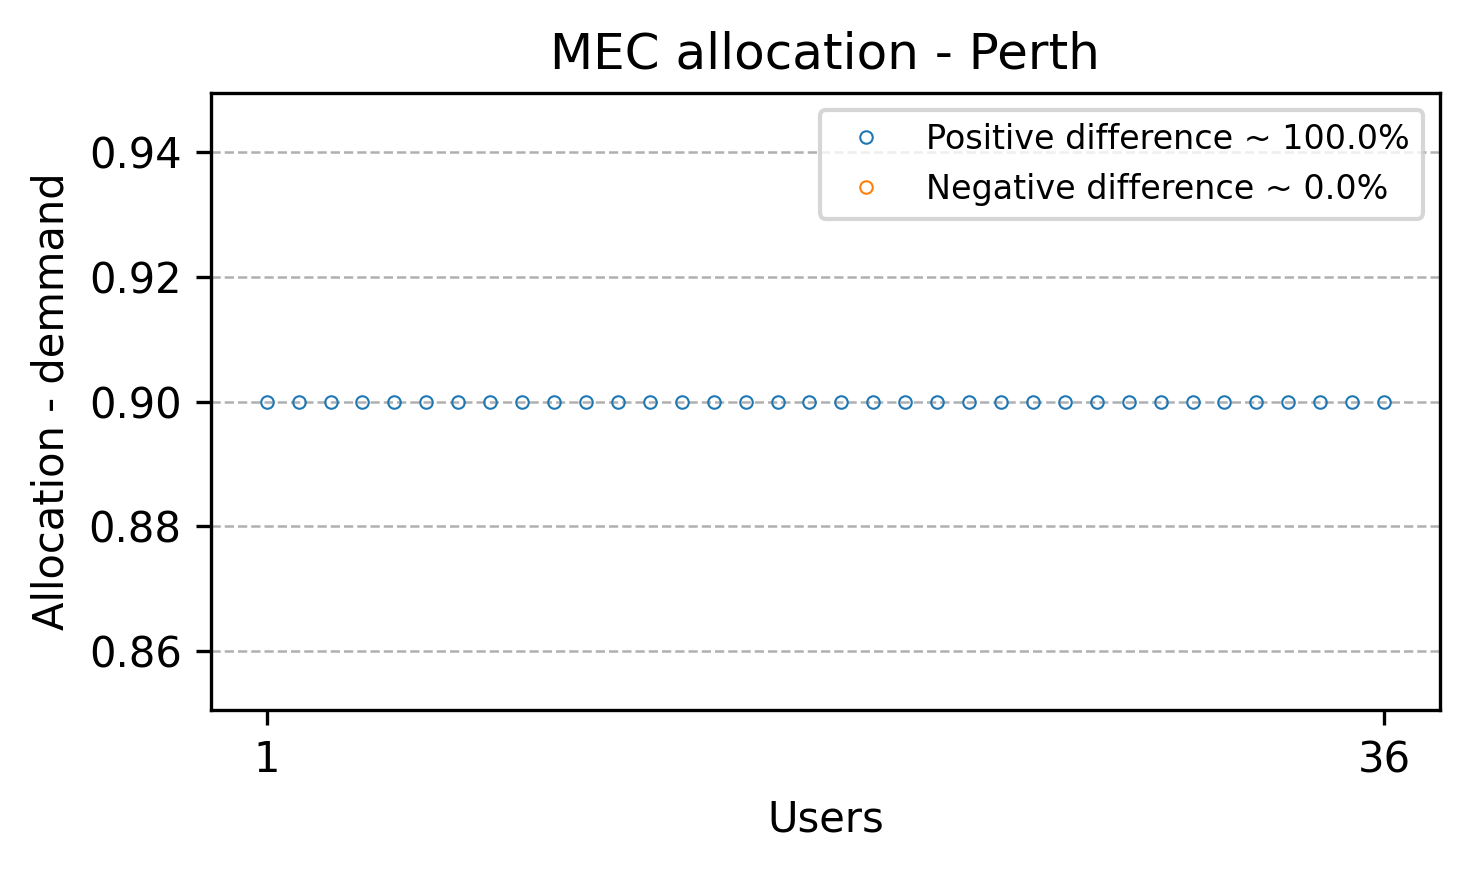

In [23]:
f = open('results/' + city + '/75_result.json')
data = json.load(f)
non_negative_b_diff, negative_b_diff, non_negative_m_diff, negative_m_diff = process_data_for_plot_diff(data)
plot_diff_mec(non_negative_m_diff, negative_m_diff)

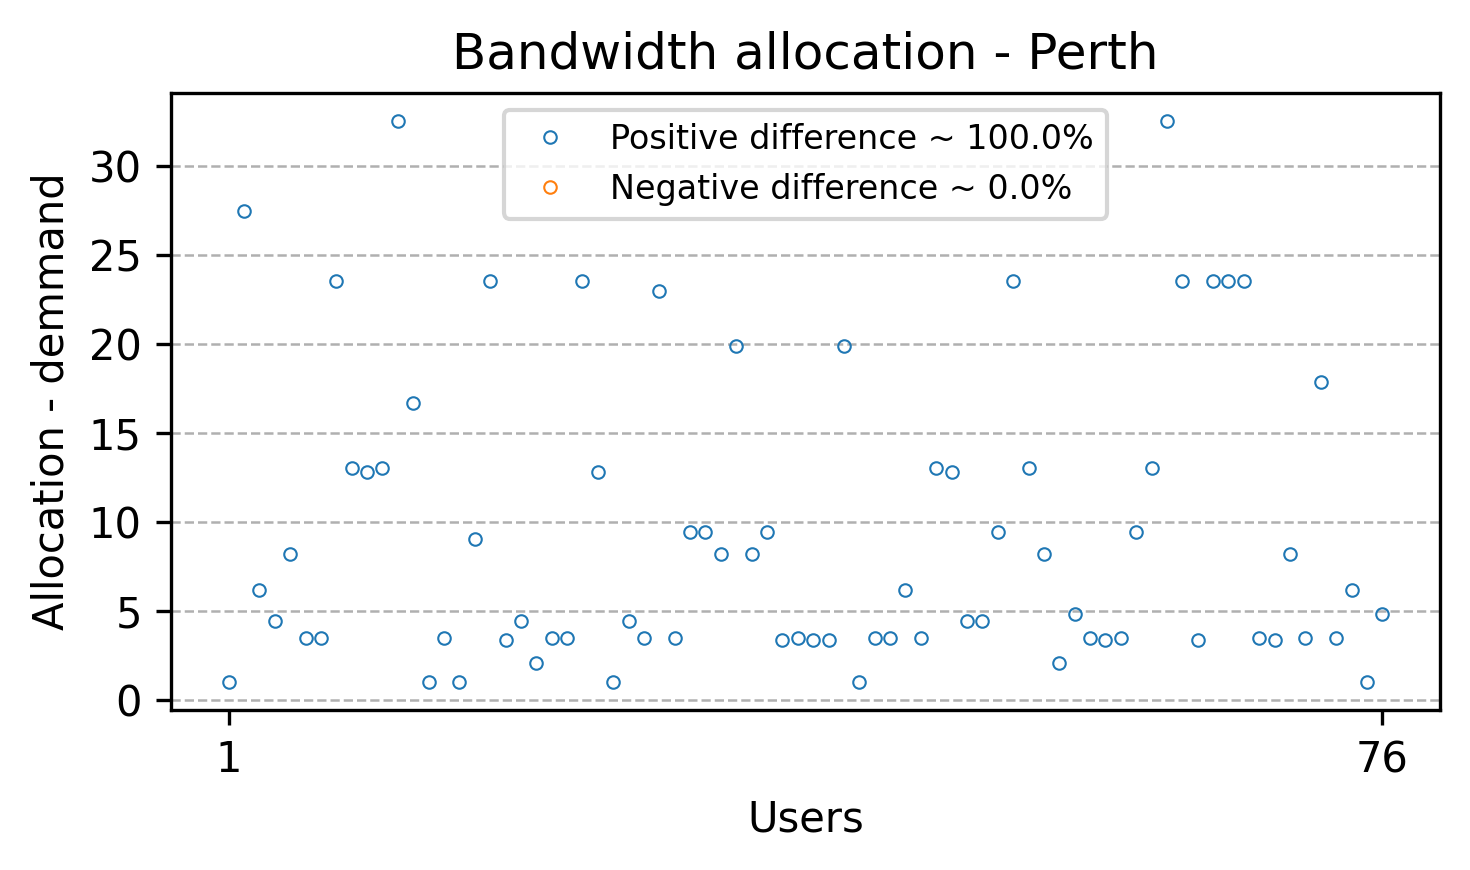

In [24]:
f = open('results/' + city + '/75_result.json')
data = json.load(f)
non_negative_b_diff, negative_b_diff, non_negative_m_diff, negative_m_diff = process_data_for_plot_diff(data)
plot_diff_band(non_negative_b_diff, negative_b_diff, 75)

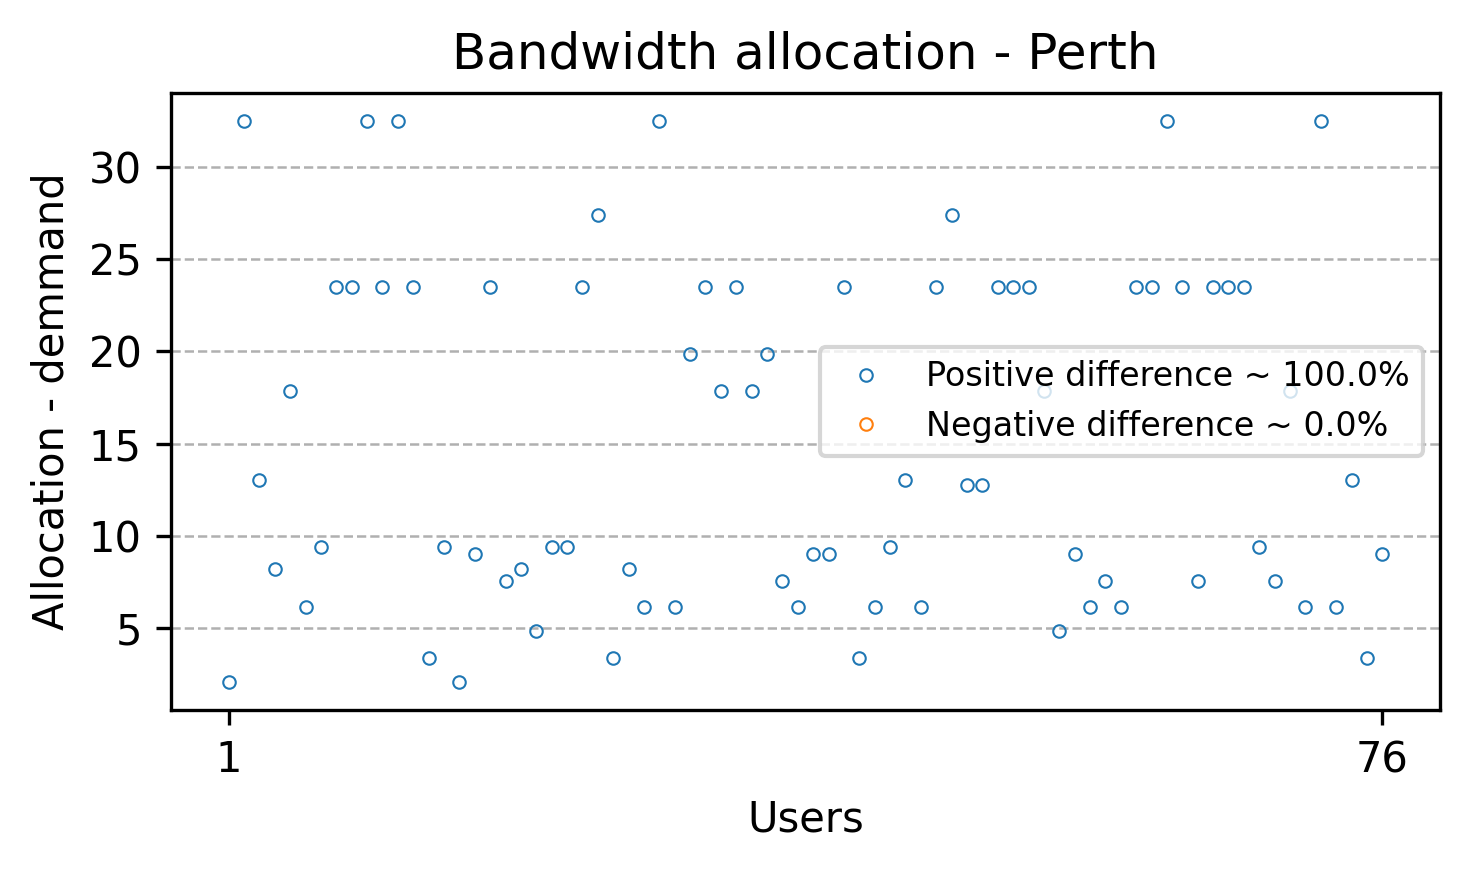

In [25]:
f = open('results/' + city + '/150_result.json')
data = json.load(f)
non_negative_b_diff, negative_b_diff, non_negative_m_diff, negative_m_diff = process_data_for_plot_diff(data)
plot_diff_band(non_negative_b_diff, negative_b_diff, 150)

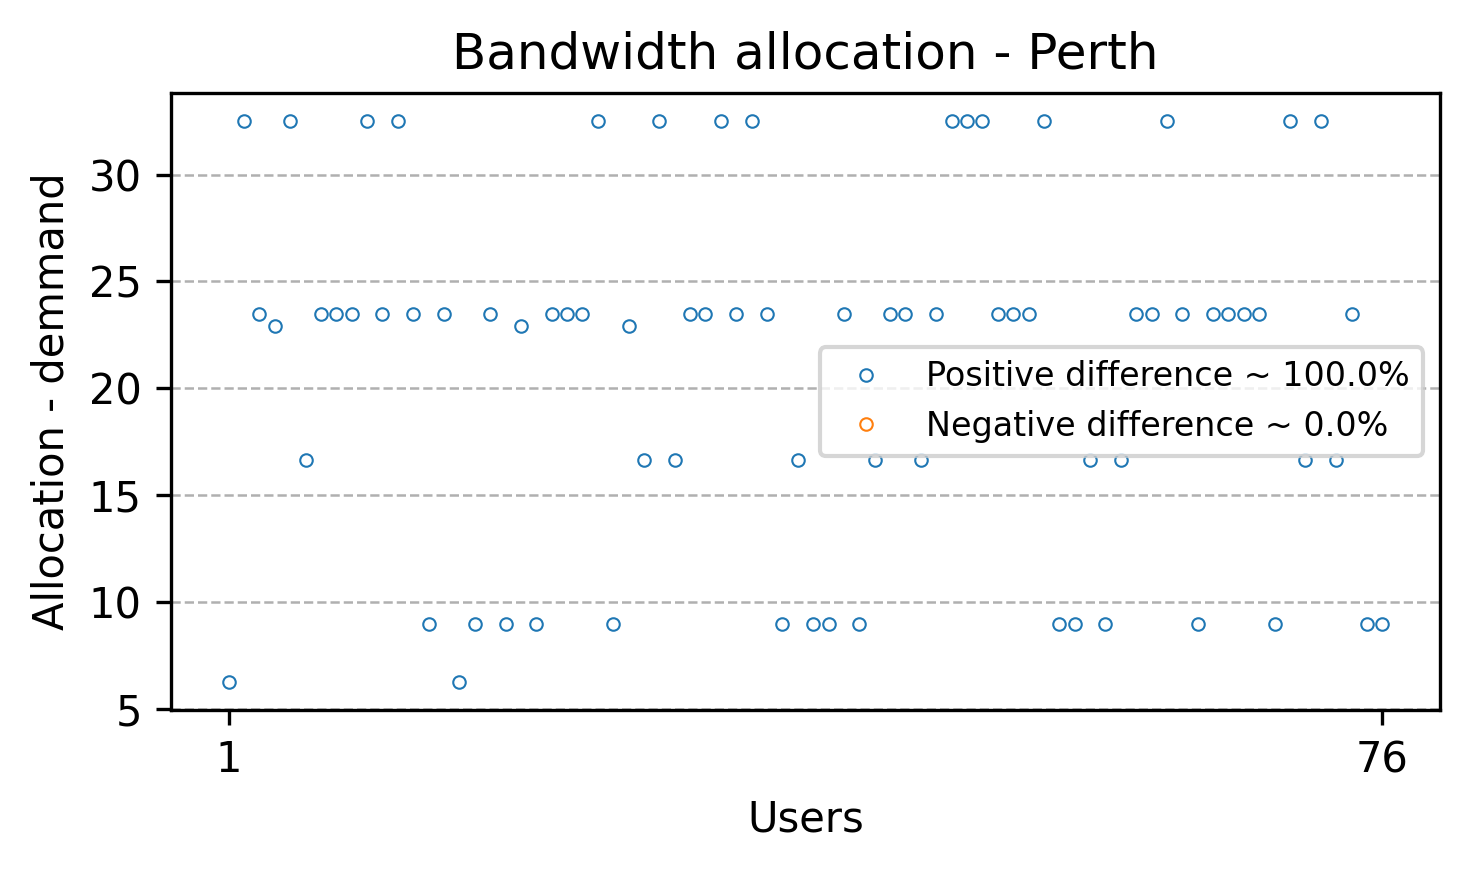

In [26]:
f = open('results/' + city + '/300_result.json')
data = json.load(f)
non_negative_b_diff, negative_b_diff, non_negative_m_diff, negative_m_diff = process_data_for_plot_diff(data)
plot_diff_band(non_negative_b_diff, negative_b_diff, 300)

## Solution Time